# FOREX Regression modelling using ML models

In this notebook, EUR-USD currency pair price prediction using neural networks and LSTM models will be studied. The performance of these models will be compared to those of SARIMA models at the end. The data used in this study is daily data extracted from `Yahoo Finance`.  

Here is the Table of contents:

[I. Neural Networks (NN)](#I.-Neural-Networks-(NN))<br>
[II. Long Short-Term Memory Networks - LSTM](#II.-Long-Short-Term-Memory-Networks---LSTM)<br>
[III. Models Comparison](#III.-Models-Comparison)

In [217]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM, Dense
import talib

## I. Neural Networks (NN)

Let's load the daily data take a look at it:

In [3]:
df = pd.read_csv("data\EURUSD_daily.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2005-05-02,1.286207,1.287498,1.284208,1.284604,1.284604,0.0
1,2005-05-03,1.284901,1.290006,1.283302,1.288693,1.288693,0.0
2,2005-05-04,1.288693,1.297202,1.287896,1.295001,1.295001,0.0
3,2005-05-05,1.295001,1.298701,1.293193,1.295605,1.295605,0.0
4,2005-05-06,1.295505,1.296395,1.281099,1.281197,1.281197,0.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3913 entries, 0 to 3912
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3913 non-null   object 
 1   Open       3885 non-null   float64
 2   High       3885 non-null   float64
 3   Low        3885 non-null   float64
 4   Close      3885 non-null   float64
 5   Adj Close  3885 non-null   float64
 6   Volume     3885 non-null   float64
dtypes: float64(6), object(1)
memory usage: 214.1+ KB


In [5]:
# Change the index format to datetime
df.index = pd.to_datetime(df['Date'], format='%Y-%m-%d')

In [6]:
# Check
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2005-05-02,2005-05-02,1.286207,1.287498,1.284208,1.284604,1.284604,0.0
2005-05-03,2005-05-03,1.284901,1.290006,1.283302,1.288693,1.288693,0.0
2005-05-04,2005-05-04,1.288693,1.297202,1.287896,1.295001,1.295001,0.0
2005-05-05,2005-05-05,1.295001,1.298701,1.293193,1.295605,1.295605,0.0
2005-05-06,2005-05-06,1.295505,1.296395,1.281099,1.281197,1.281197,0.0


The `Date` and `Volume` columns will be dropped since there is no extra information in them.

In [7]:
# Dropping Date and Volume columns
df.drop(columns=['Date', 'Volume'], inplace=True)

In [8]:
# Check
df.head()

,Open,High,Low,Close,Adj Close
Date,,,,,
2005-05-02,1.286207,1.287498,1.284208,1.284604,1.284604
2005-05-03,1.284901,1.290006,1.283302,1.288693,1.288693
2005-05-04,1.288693,1.297202,1.287896,1.295001,1.295001
2005-05-05,1.295001,1.298701,1.293193,1.295605,1.295605
2005-05-06,1.295505,1.296395,1.281099,1.281197,1.281197


### Data for the modelling part

The `Close` price will be used for the modelling part in this study.

In [255]:
df_model = df['Close'].to_frame()

Five years of data will be used for the modelling part.

In [256]:
start_date = '2015-01-01'
end_date = '2020-01-01'
df_model = df_model[(df_model.index >= start_date) & (df_model.index < end_date)]
df_model.head()

,Close
Date,
2015-01-01,1.209863
2015-01-02,1.208941
2015-01-05,1.194643
2015-01-06,1.193902
2015-01-07,1.187536


In [257]:
df_model.isna().sum()

Close    3
dtype: int64

In [258]:
# Filling nan values
df_model.fillna(method='ffill', inplace=True) 

In [259]:
df_model.isna().sum()

Close    0
dtype: int64

The number of timestamps in the past (lags) should be specified for the input variable.

In [260]:
# Add lagged features
lags = 30  # Number of previous time steps to consider
for i in range(1, lags + 1):
    df_model[f'Close Lag {i}'] = df_model['Close'].shift(i)

df_model.dropna(inplace=True)

# Split the data into input features (X) and target variable (y)
X = df_model.drop('Close', axis=1).values
y = df_model['Close'].values.reshape(-1, 1)

# Split the data into training and testing sets
split_index = int(len(df_model) * 0.8)
X_train = X[:split_index]
X_test = X[split_index:]
y_train = y[:split_index]
y_test = y[split_index:]

In [261]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1019, 30), (255, 30), (1019, 1), (255, 1))

As can be seen, the input and output shapes are corresponding to each other.

To find the best hyperparameters, a pipeline will be used. 

In [262]:
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# Set the random seed for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

# Create the function to build the feedforward neural network model
def build_model(hidden_neurons=32, activation='relu'):
    model = Sequential()
    model.add(Dense(hidden_neurons, activation=activation, input_shape=(X_train.shape[1],)))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Create the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', KerasRegressor(build_fn=build_model, verbose=0))
])

# Define the hyperparameters to search over
parameters = {
    'model__batch_size': [32],
    'model__epochs': [100, 200],
    'model__hidden_neurons': [8, 16, 32, 64],
    'model__activation': ['relu', 'sigmoid']
}

# Create the grid search object
grid_search = GridSearchCV(pipeline, parameters, cv=5)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        <tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x0000023417A5DE20>)]),
             param_grid={'model__activation': ['relu', 'sigmoid'],
                         'model__batch_size': [32], 'model__epochs': [100, 200],
                         'model__hidden_neurons': [8, 16, 32, 64]})

In [263]:
# Getting the best parameters 
grid_search.best_params_

{'model__activation': 'sigmoid',
 'model__batch_size': 32,
 'model__epochs': 200,
 'model__hidden_neurons': 16}

In [264]:
# Get the best model and its performance
best_model = grid_search.best_estimator_

In [265]:
# Get the predictions
test_predictions_nn = best_model.predict(X_test)

In [266]:
# Calculate RMSE
rmse = np.sqrt(np.mean((test_predictions_nn - y_test[:,0]) ** 2))

# Calculate MAPE
mape = np.mean(np.abs((test_predictions_nn - y_test[:,0]) / y_test[:,0])) * 100

# Calculate NSE
nse = 1 - np.sum((y_test[:,0] - test_predictions_nn) ** 2) / np.sum((y_test[:,0] - np.mean(y_test[:,0])) ** 2)

print("RMSE:", rmse)
print("MAPE:", mape)
print("NSE:", nse)


RMSE: 0.004794888582183882
MAPE: 0.34515505743388236
NSE: 0.8699550332485696


### Plotting the predictions
Let's plot the predictions for the traning and test sets.

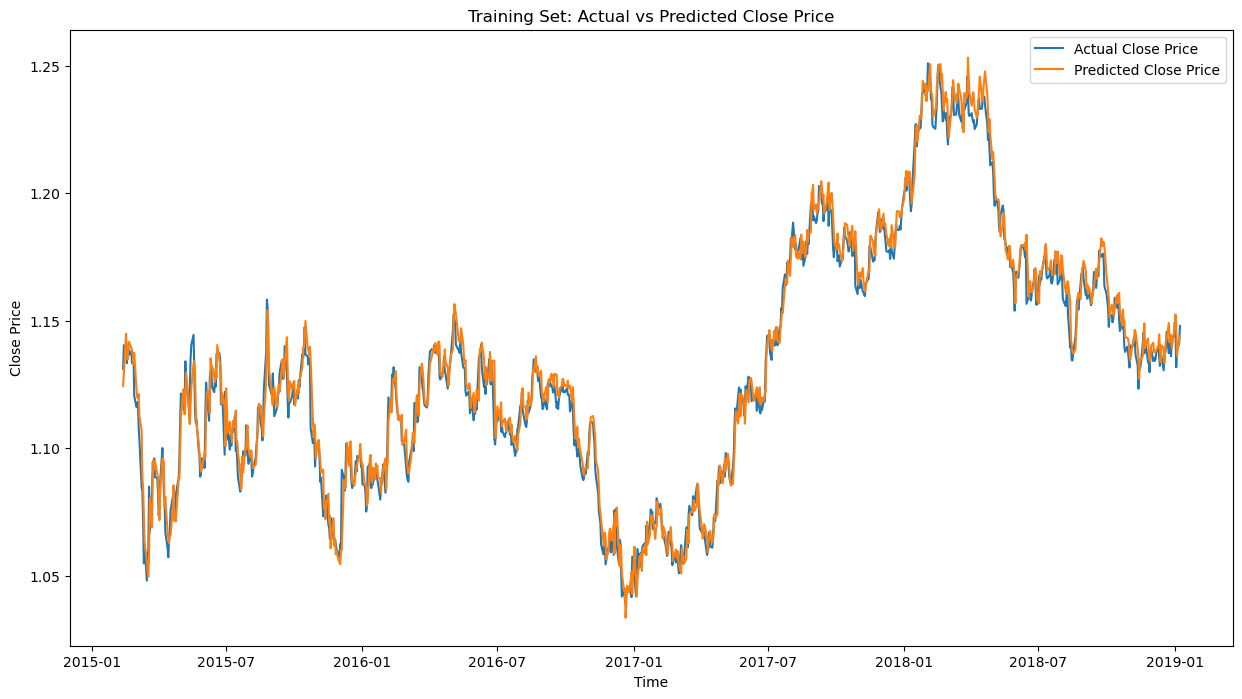

In [102]:
# Generate predictions on the training set
train_predictions_nn_uni = best_model.predict(X_train)

# Plotting
plt.figure(figsize=(15, 8))
plt.plot(df_model.index[:split_index], y_train, label='Actual Close Price')
plt.plot(df_model.index[:split_index], train_predictions_nn_uni, label='Predicted Close Price')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Training Set: Actual vs Predicted Close Price')
plt.legend()
plt.show()

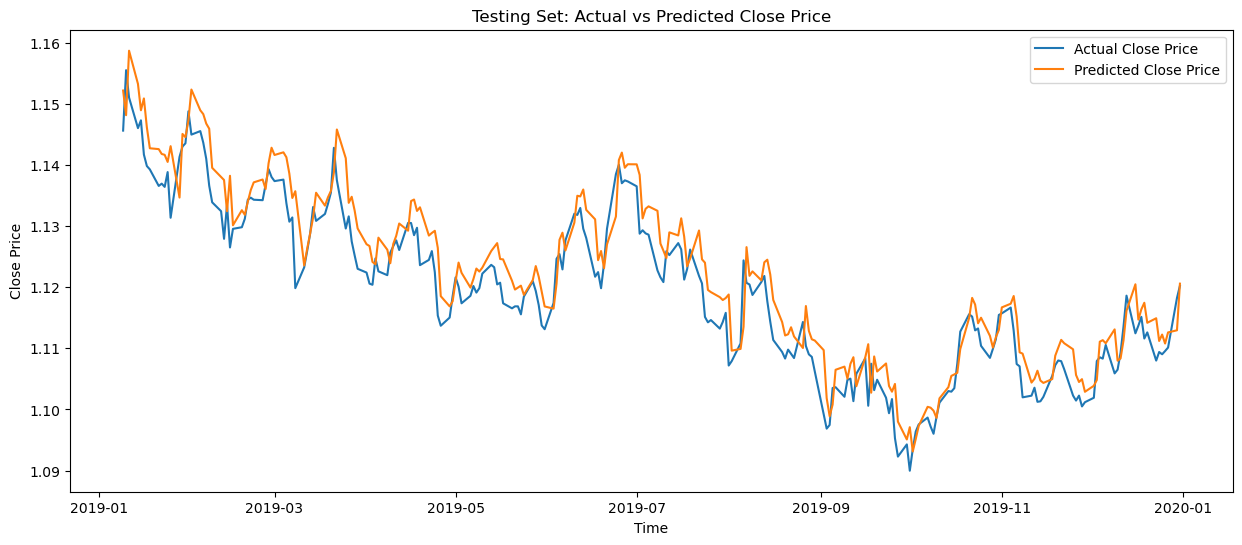

In [103]:
# Plotting test set predictions
plt.figure(figsize=(15, 6))
plt.plot(df_model.index[split_index:], y_test, label='Actual Close Price')
plt.plot(df_model.index[split_index:], test_predictions_nn_uni, label='Predicted Close Price')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Testing Set: Actual vs Predicted Close Price')
plt.legend()
plt.show()

It can be seen that the predictions are following the trend of the actual values with a lag.

In the next part, LSTM model will be studied.

## II. Long Short-Term Memory Networks - LSTM

In [269]:
df_model = df['Close'].to_frame()

In [270]:
start_date = '2015-01-01'
end_date = '2020-01-01'
df_model = df_model[(df_model.index >= start_date) & (df_model.index < end_date)]
df_model.head()

,Close
Date,
2015-01-01,1.209863
2015-01-02,1.208941
2015-01-05,1.194643
2015-01-06,1.193902
2015-01-07,1.187536


In [271]:
df_model.isna().sum()

Close    3
dtype: int64

In [272]:
# Filling nan values
df_model.fillna(method='ffill', inplace=True) 

In [273]:
df_model.isna().sum()

Close    0
dtype: int64

In [274]:
# Add lagged features
lags = 30  # Number of previous time steps to consider
for i in range(1, lags + 1):
    df_model[f'Close Lag {i}'] = df_model['Close'].shift(i)

df_model.dropna(inplace=True)

# Split the data into input features (X) and target variable (y)
X = df_model.drop('Close', axis=1).values
y = df_model['Close'].values.reshape(-1, 1)

# Split the data into training and testing sets
split_index = int(len(df_model) * 0.8)
X_train = X[:split_index]
X_test = X[split_index:]
y_train = y[:split_index]
y_test = y[split_index:]

# Normalize the input features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape the input data for LSTM (samples, timesteps, features)
X_train = X_train.reshape(X_train.shape[0], lags, -1)
X_test = X_test.reshape(X_test.shape[0], lags, -1)

In [275]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1019, 30, 1), (255, 30, 1), (1019, 1), (255, 1))

The input and output shapes are corresponding to each other.

To find the best hyperparameters, a pipeline will be used. 

In [248]:
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# Set the random seed for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

# Function to create the LSTM model
def create_model(hidden_neurons=32, activation='relu'):
    model = Sequential()
    model.add(LSTM(hidden_neurons, activation=activation, return_sequences=False, input_shape=(lags, X_train.shape[2])))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mse')
    return model

# Create the pipeline
pipeline = Pipeline([
        ('model', KerasRegressor(build_fn=create_model, verbose=0))
])

# Define the hyperparameters to search over
parameters = {
    'model__batch_size': [32],
    'model__epochs': [100, 200],
    'model__hidden_neurons': [8, 16, 32, 64],
    'model__activation': ['relu', 'sigmoid'],
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline, parameters, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('model',
                                        <tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x000002340968F550>)]),
             param_grid={'model__activation': ['relu', 'sigmoid'],
                         'model__batch_size': [32], 'model__epochs': [100, 200],
                         'model__hidden_neurons': [8, 16, 32, 64]})

In [249]:
# Getting the best parameters 
grid_search.best_params_

{'model__activation': 'relu',
 'model__batch_size': 32,
 'model__epochs': 200,
 'model__hidden_neurons': 32}

In [250]:
# Get the best model and its performance
best_model = grid_search.best_estimator_

In [251]:
# Get the predictions
test_predictions_lstm = best_model.predict(X_test)

In [252]:
# Calculate RMSE
rmse = np.sqrt(np.mean((test_predictions_lstm - y_test[:,0]) ** 2))

# Calculate MAPE
mape = np.mean(np.abs((test_predictions_lstm - y_test[:,0]) / y_test[:,0])) * 100

# Calculate NSE
nse = 1 - np.sum((y_test[:,0] - test_predictions_lstm) ** 2) / np.sum((y_test[:,0] - np.mean(y_test[:,0])) ** 2)

print("RMSE:", rmse)
print("MAPE:", mape)
print("NSE:", nse)


RMSE: 0.0039147444886341795
MAPE: 0.27048427678554976
NSE: 0.9133151203310724


### Plotting the predictions
Let's plot the predictions for the traning and test sets.

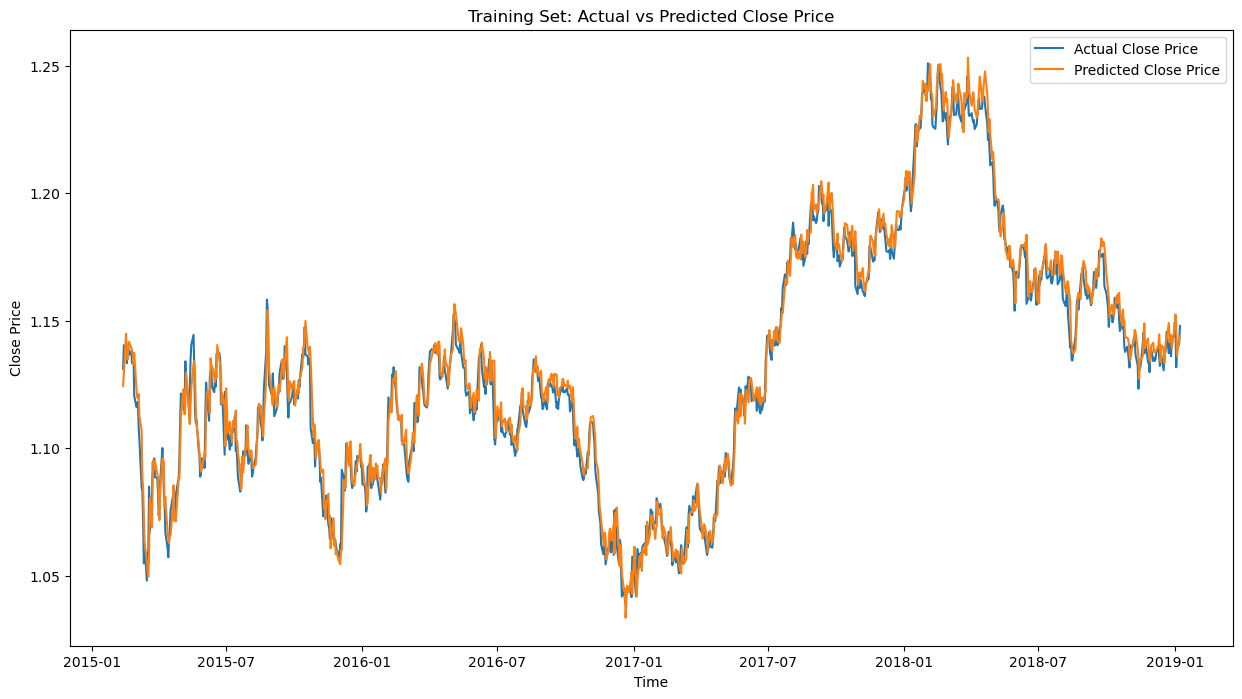

In [253]:
# Generate predictions on the training set
train_predictions_lstm = best_model.predict(X_train)

# Plotting
plt.figure(figsize=(15, 8))
plt.plot(df_model.index[:split_index], y_train, label='Actual Close Price')
plt.plot(df_model.index[:split_index], train_predictions_nn_uni, label='Predicted Close Price')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Training Set: Actual vs Predicted Close Price')
plt.legend()
plt.show()

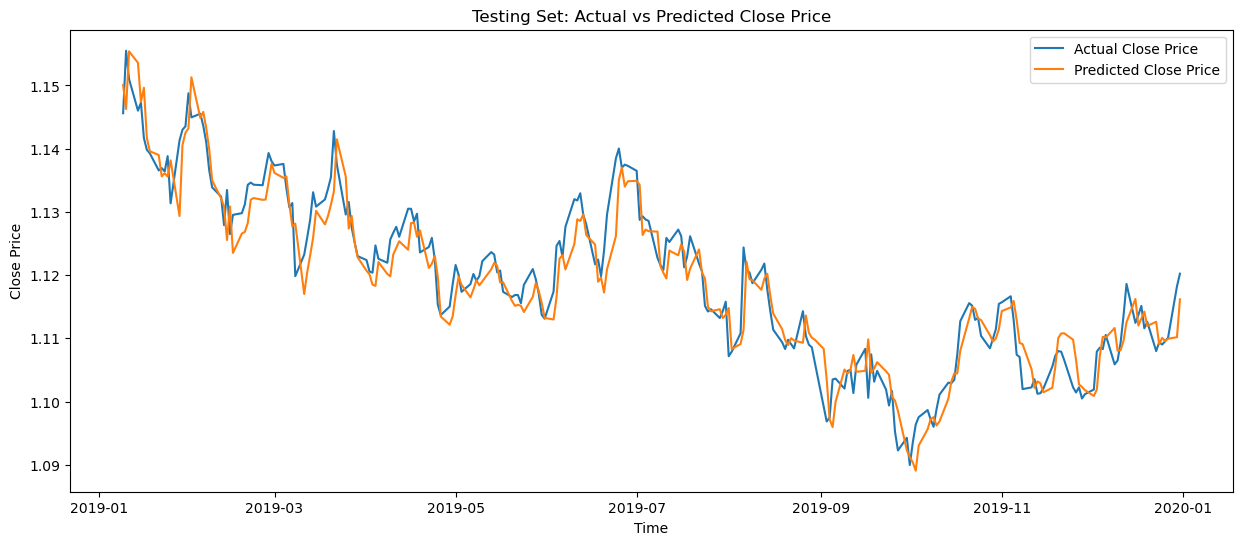

In [254]:
# Plotting test set predictions
plt.figure(figsize=(15, 6))
plt.plot(df_model.index[split_index:], y_test, label='Actual Close Price')
plt.plot(df_model.index[split_index:], test_predictions_lstm, label='Predicted Close Price')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Testing Set: Actual vs Predicted Close Price')
plt.legend()
plt.show()

### III. Models Comparison

In [278]:
predictions = pd.DataFrame({
    'NN_model': test_predictions_nn,
    'LSTM_model': test_predictions_lstm,
    'Actual_data': y_test[:,0],
})
predictions

,NN_model,LSTM_model,Actual_data
0,1.152165,1.150065,1.145607
1,1.148128,1.146270,1.155495
2,1.158677,1.155398,1.151013
3,1.153246,1.153581,1.146014
4,1.148933,1.147411,1.147289
...,...,...,...
250,1.112241,1.110085,1.109016
251,1.110775,1.109586,1.109545
252,1.112594,1.109944,1.110112
253,1.112939,1.110182,1.118230


In [280]:
# Calculate RMSE
rmse_nn = np.sqrt(((predictions['Actual_data'] - predictions['NN_model']) ** 2).mean())
rmse_lstm = np.sqrt(((predictions['Actual_data'] - predictions['LSTM_model']) ** 2).mean())

# Calculate MAPE
mape_nn = np.mean(np.abs((predictions['Actual_data'] - predictions['NN_model']) / predictions['Actual_data'])) * 100
mape_lstm = np.mean(np.abs((predictions['Actual_data'] - predictions['LSTM_model']) / predictions['Actual_data'])) * 100

# Calculate NSE
nse_nn = 1 - np.sum((predictions['NN_model'] - predictions['Actual_data']) ** 2) / np.sum((predictions['Actual_data'] - np.mean(predictions['Actual_data'])) ** 2)
nse_lstm = 1 - np.sum((predictions['LSTM_model'] - predictions['Actual_data']) ** 2) / np.sum((predictions['Actual_data'] - np.mean(predictions['Actual_data'])) ** 2)


In [282]:
# Create a DataFrame for the metrics
metrics_df = pd.DataFrame({
    'RMSE': [rmse_nn, rmse_lstm],
    'MAPE': [mape_nn, mape_lstm],
    'NSE': [nse_nn, nse_lstm]
}, index=['NN Model', 'LSTM Model'])

# Transpose the DataFrame
metrics_df = metrics_df.transpose()

metrics_df

,NN Model,LSTM Model
RMSE,0.004795,0.003915
MAPE,0.345155,0.270484
NSE,0.869955,0.913315


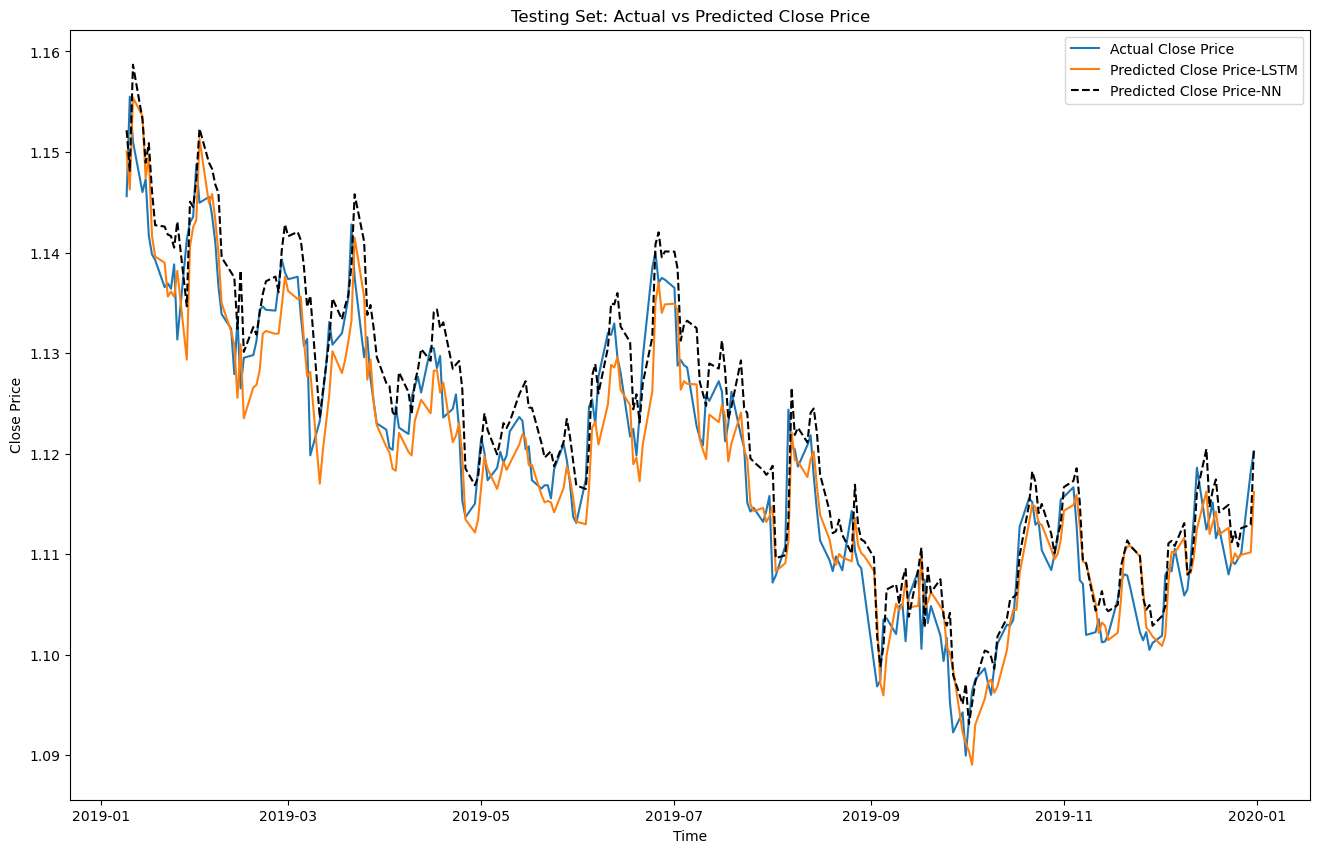

In [290]:
# Plotting test set predictions
plt.figure(figsize=(16, 10))
plt.plot(df_model.index[split_index:], y_test, label='Actual Close Price')
plt.plot(df_model.index[split_index:], test_predictions_lstm, label='Predicted Close Price-LSTM')
plt.plot(df_model.index[split_index:], test_predictions_nn, 'k--', label='Predicted Close Price-NN')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Testing Set: Actual vs Predicted Close Price')
plt.legend()
plt.show()

From the SARIMA models, we had the performance:

Univariate Model	Multivariate Model
RMSE	0.027748	0.005652
MAPE	2.203005	0.428069
NSE	   -3.145579	0.828033

Let's add these to the ML models performance and plot the comparison.

In [303]:
# Create a DataFrame for the additional metrics
additional_metrics = pd.DataFrame({
    'SARIMA-Univariate': [0.027748, 2.203005, -3.145579],
    'SARIMA-Multivariate': [0.005652, 0.428069, 0.828033]
}, index=['RMSE', 'MAPE', 'NSE'])

# Concatenate the DataFrames
metrics_df_all = pd.concat([metrics_df, additional_metrics], axis=1)

# Transpose the DataFrame
#metrics_df_all = metrics_df_all.transpose()

In [304]:
metrics_df_all

,NN Model,LSTM Model,SARIMA-Univariate,SARIMA-Multivariate
RMSE,0.004795,0.003915,0.027748,0.005652
MAPE,0.345155,0.270484,2.203005,0.428069
NSE,0.869955,0.913315,-3.145579,0.828033


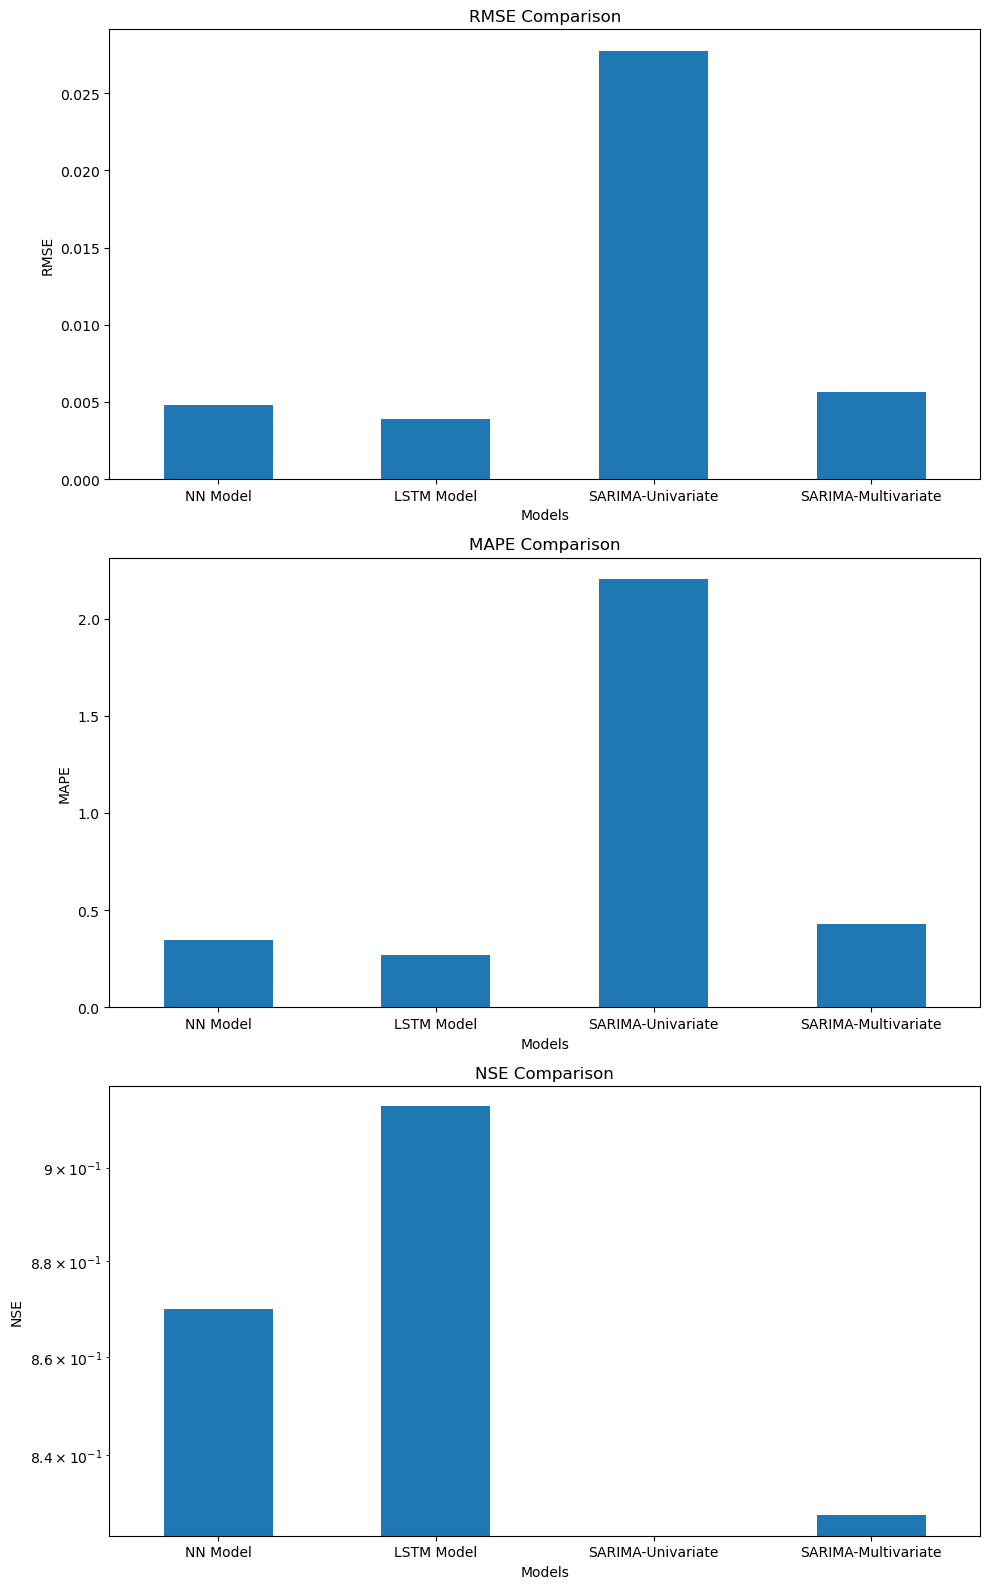

In [305]:
# Create subplots for each metric
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 16))

# Plot RMSE
metrics_df_all.loc['RMSE'].plot(kind='bar', ax=axes[0])
axes[0].set_title('RMSE Comparison')
axes[0].set_xlabel('Models')
axes[0].set_ylabel('RMSE')

# Plot MAPE
metrics_df_all.loc['MAPE'].plot(kind='bar', ax=axes[1])
axes[1].set_title('MAPE Comparison')
axes[1].set_xlabel('Models')
axes[1].set_ylabel('MAPE')

# Plot NSE
metrics_df_all.loc['NSE'].plot(kind='bar', ax=axes[2])
axes[2].set_title('NSE Comparison')
axes[2].set_xlabel('Models')
axes[2].set_ylabel('NSE')
axes[2].set_yscale('log')

# Rotate x-axis tick labels horizontally
for ax in axes:
    ax.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()


From the plots above it can be seen that LSTM has outperformed other models in terms of having the lowest RMSE and MAPE and highest NSE.